In [1]:
## Imports ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import (LeaveOneOut, RandomizedSearchCV,
                                     RepeatedKFold, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
## Read in Data ## 
df_orig = pd.read_csv('../data/processed/CPA-virtual_database.csv')
df = df_orig[df_orig['Rxn_Type'] == 'Training']

y, x = df.loc[:, 'ddG'],df.loc[:, df.columns[9:]]

In [3]:
## Train-test split ##
 
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=25)

In [4]:
## Normalise Data ##
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [5]:
## Hyperparameter Tuning ##

hp_n_neighbours = range(1,20)
hp_weights = ['uniform','distance']
hp_algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hp_leaf_size = range(1,60)
hp_p = [1,2]

random_grid = {'n_neighbors': hp_n_neighbours,
               'weights': hp_weights,
               'algorithm': hp_algorithm,
               'leaf_size': hp_leaf_size,
               'p': hp_p
               }

In [6]:
regressor = KNeighborsRegressor()

hp_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, cv=10, n_iter=500,scoring='r2', random_state=25)
hp_random.fit(X_train, y_train)
print(hp_random.best_params_)
hp_tune_1 = pd.DataFrame(hp_random.cv_results_)

{'weights': 'distance', 'p': 1, 'n_neighbors': 4, 'leaf_size': 41, 'algorithm': 'auto'}


In [7]:
## Hyperparameter Tuning 2##

hp_n_neighbours = range(3,7)
hp_weights = ['uniform','distance']
hp_algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hp_leaf_size = range(1,50)

random_grid = {'n_neighbors': hp_n_neighbours,
               'weights': hp_weights,
               'algorithm': hp_algorithm,
               'leaf_size': hp_leaf_size,
               }

In [9]:
from sklearn.model_selection import GridSearchCV


regressor = KNeighborsRegressor(p=1)

hp_random = GridSearchCV(estimator = regressor, param_grid = random_grid, cv=10,scoring='r2')
hp_random.fit(X_train, y_train)
print(hp_random.best_params_)
hp_tune_2 = pd.DataFrame(hp_random.cv_results_)

{'algorithm': 'kd_tree', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}


In [5]:
## Train Model ##
regressor_tuned = KNeighborsRegressor(n_neighbors=3,weights='distance',algorithm='kd_tree', leaf_size=2,p=1)
model = regressor_tuned.fit(X_train, y_train)
train_predict = model.predict(X_train)

Train MAE = 0.057938144329896905
Train R^2 = 0.9861336855168095


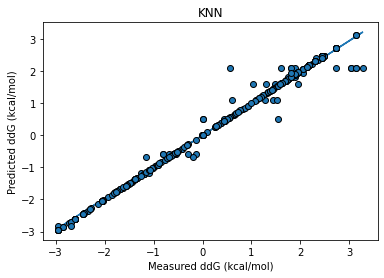

In [6]:
## Plot Training Model ##

plt.scatter(y_train,train_predict, edgecolor='black')
print('Train MAE = ' + str(mae(y_train,train_predict)))
print('Train R^2 = ' + str(r2_score(y_train,train_predict)))
plt.xlabel('Measured ddG (kcal/mol)')
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('KNN')
m, b = np.polyfit(y_train, train_predict, 1)
plt.plot(y_train,m*y_train+b, zorder = 0)

In [16]:
# K-fold Cross validation score
from sklearn.model_selection import cross_val_predict


rep_cv = RepeatedKFold(n_splits=10,n_repeats=10)
cv_model = cross_validate(
    regressor_tuned,
    X_train,
    y_train,
    cv = rep_cv,
    scoring=('r2','neg_mean_absolute_error')
)
cv_r2 = (np.average(cv_model['test_r2']))

#LOO
loo = LeaveOneOut()
loo_model = cross_val_predict(
    regressor_tuned,
    X_train,
    y_train,
    cv = loo,
)
loo_r2 = r2_score(y_train,loo_model)  


In [7]:
## Predict X Test ##

X_test_ = scaler.transform(X_test)
test_predict = model.predict(X_test_)

Test MAE = 0.23868946492106505
Test R^2 = 0.96045074387336


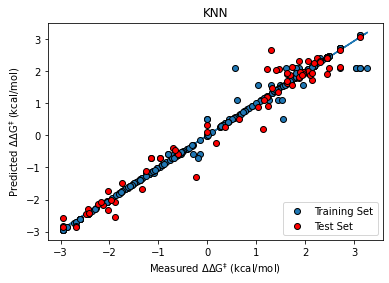

In [8]:
## Plot Test Model ##

plt.plot(y_train,m*y_train+b, zorder = 0)

plt.scatter(y_train,train_predict, edgecolor = 'black', zorder = 15, label = 'Training Set')

plt.scatter(y_test,test_predict, facecolor='red', edgecolor = 'black', zorder = 20, label = 'Test Set')

plt.title('KNN')
plt.xlabel('Measured $\Delta\Delta$G$^‡$ (kcal/mol)')
plt.ylabel('Predicted $\Delta\Delta$G$^‡$ (kcal/mol)')
plt.legend(loc="lower right")
print('Test MAE = ' + str(mae(y_test,test_predict)))
print('Test R^2 = ' + str(r2_score(y_test,test_predict)))